In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.enable_eager_execution()
tf.random.set_random_seed(13)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
from keras import regularizers
import math
from sklearn.metrics import mean_squared_error
import os

In [5]:
!pip install wget

path = './drive/My Drive/Stock_price/data/btc_1h'

import finplot as fplt
import numpy as np
import pandas as pd
import wget

# pull some data
url = 'http://www.cryptodatadownload.com/cdd/Coinbase_BTCUSD_1h.csv'
table = wget.download(url)

In [ ]:
data = pd.read_csv('Coinbase_BTCUSD_1h.csv', header = 1, index_col = 'Date')
data = data.reindex(index = data.index[::-1])

In [7]:
data

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2017-07-01 11-AM,BTCUSD,2505.56,2513.38,2495.12,2509.17,114.60,287000.32
2017-07-01 12-PM,BTCUSD,2509.17,2512.87,2484.99,2488.43,157.36,393142.50
2017-07-01 01-PM,BTCUSD,2488.43,2488.43,2454.40,2454.43,280.28,693254.01
2017-07-01 02-PM,BTCUSD,2454.43,2473.93,2450.83,2459.35,289.42,712864.80
2017-07-01 03-PM,BTCUSD,2459.35,2475.00,2450.00,2467.83,276.82,682105.41
...,...,...,...,...,...,...,...
2019-11-28 03-PM,BTCUSD,7464.11,7647.85,7460.70,7621.76,1252.14,9493665.21
2019-11-28 04-PM,BTCUSD,7621.76,7624.00,7545.81,7616.27,1046.33,7925769.91
2019-11-28 05-PM,BTCUSD,7616.27,7627.15,7580.41,7590.09,321.86,2445797.90


In [ ]:
def heikin_ashi(df):
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['Open', 'High', 'Low', 'Close'])
    
    heikin_ashi_df['Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    
    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['Open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i-1, 0] + heikin_ashi_df.iat[i-1, 3]) / 2
        
    heikin_ashi_df['High'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['High']).max(axis=1)
    
    heikin_ashi_df['Low'] = heikin_ashi_df.loc[:, ['Open', 'Close']].join(df['Low']).min(axis=1)
    
    return heikin_ashi_df

In [ ]:
ha = heikin_ashi(data)

In [10]:
ha

,Open,High,Low,Close
2017-07-01 11-AM,2505.56,2513.380000,2495.120000,2505.8075
2017-07-01 12-PM,2505.68,2512.870000,2484.990000,2498.8650
2017-07-01 01-PM,2502.27,2502.274375,2454.400000,2471.4225
2017-07-01 02-PM,2486.85,2486.848437,2450.830000,2459.6350
2017-07-01 03-PM,2473.24,2475.000000,2450.000000,2463.0450
...,...,...,...,...
2019-11-28 03-PM,7470.5,7647.850000,7460.700000,7548.6050
2019-11-28 04-PM,7509.55,7624.000000,7509.553290,7601.9600
2019-11-28 05-PM,7555.76,7627.150000,7555.756645,7603.4800
2019-11-28 06-PM,7579.62,7643.150000,7579.618322,7603.8525


In [ ]:
def cumcnt_indices(v):
    v[~v] = pd.np.nan
    cumsum = v.cumsum().fillna(method='pad')
    reset = -cumsum[v.isnull()].diff().fillna(cumsum)
    r = v.where(v.notnull(), reset).cumsum().fillna(0.0)
    return r.astype(int)

def td_sequential(close):
    close4 = close.shift(4)
    td = cumcnt_indices(close > close4)
    ts = cumcnt_indices(close < close4)
    return td, ts

def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    #dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    #dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    # Create Exponential moving average
    #dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    return dataset

tdup,tddn = td_sequential(ha['Close'])
ha['tdup'] = [(i if 0<i<10 else 0) for i in tdup]
ha['tddn'] = [(i if 0<i<10 else 0) for i in tddn]

ha['td'] = ha['tdup'] - ha['tddn']
ha = get_technical_indicators(ha)
ha = ha.drop(columns = ['tdup', 'tddn'])

In [12]:
ha.head()

,Open,High,Low,Close,td,26ema,12ema,MACD
2017-07-01 11-AM,2505.56,2513.380000,2495.12,2505.8075,0,2505.807500,2505.807500,0.000000
2017-07-01 12-PM,2505.68,2512.870000,2484.99,2498.8650,0,2502.202740,2502.046979,-0.155761
2017-07-01 01-PM,2502.27,2502.274375,2454.40,2471.4225,0,2491.143699,2490.094238,-1.049461
2017-07-01 02-PM,2486.85,2486.848437,2450.83,2459.6350,0,2482.335244,2480.479447,-1.855797
2017-07-01 03-PM,2473.24,2475.000000,2450.00,2463.0450,-1,2477.861757,2475.742570,-2.119187


In [13]:
ha.isna().any()

Open     False
High     False
Low      False
Close    False
td       False
26ema    False
12ema    False
MACD     False
dtype: bool

In [ ]:
ha = ha.bfill()

In [15]:
ha.isna().any()

Open     False
High     False
Low      False
Close    False
td       False
26ema    False
12ema    False
MACD     False
dtype: bool

In [ ]:
ha = ha.drop(columns=['Open', 'High', 'Low', 'Close', '26ema', '12ema'])
reg = data['Close']

In [ ]:
df = pd.concat([ha, reg], axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7feb1f219b70>,
      dtype=object)

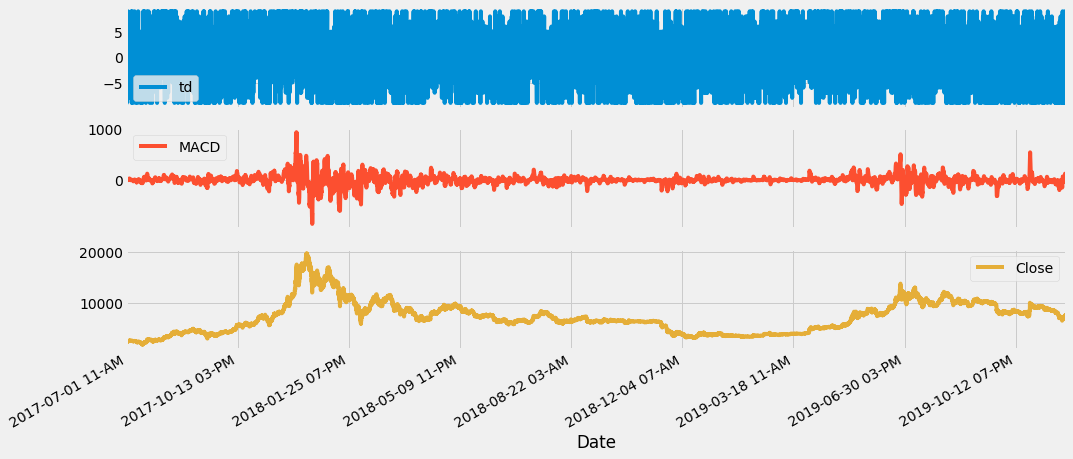

In [18]:
df.plot(subplots=True, figsize=(15,7))

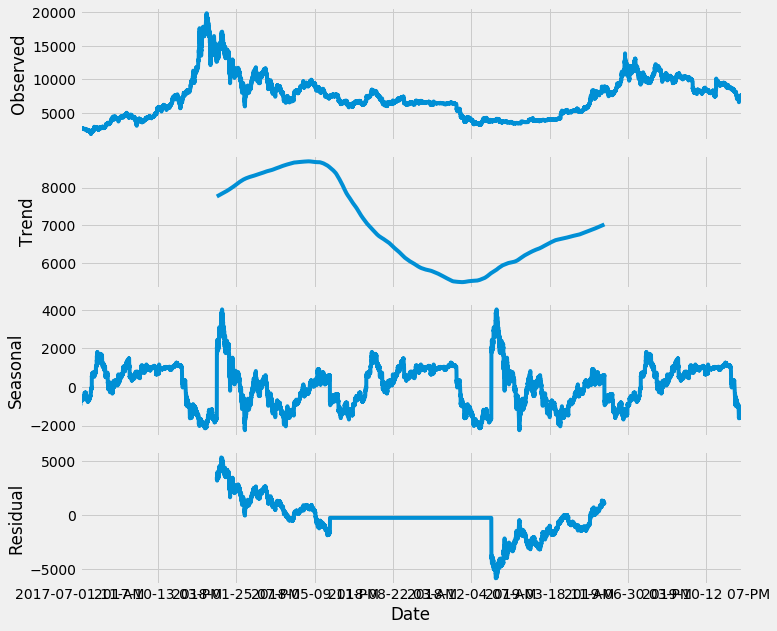

In [19]:
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 11, 9
decomposed = sm.tsa.seasonal_decompose(df['Close'],freq=365*24) # annual frequency
figure = decomposed.plot()
plt.show()

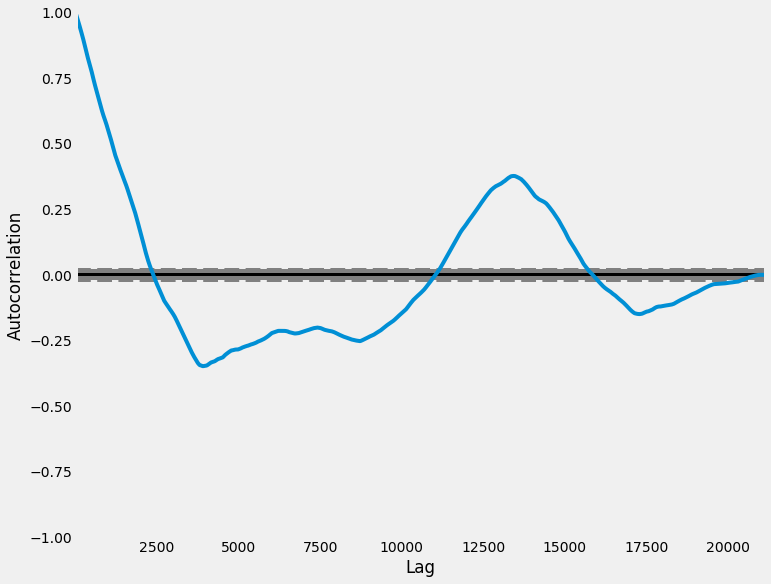

In [20]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Close'])

In [ ]:
import xgboost as xgb

def get_feature_importance_data(dataframe):
    data = dataframe.copy()
    y = data['Close']
    X = data.drop(columns=['Close'])
    
    train_samples = int(X.shape[0] * 0.7)

    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [ ]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df)

In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0, n_estimators=150, base_score=0.7, colsample_bytree=1, learning_rate=0.05)

In [24]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
eval_result = regressor.evals_result()

In [ ]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

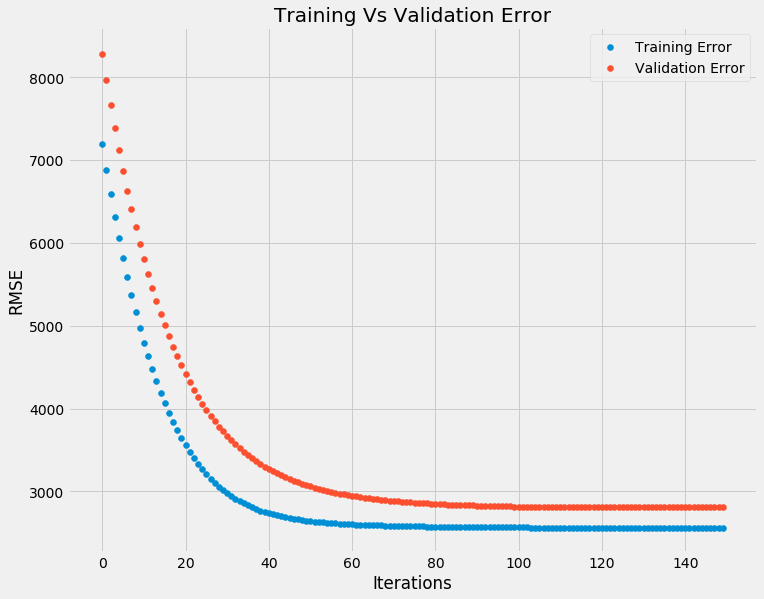

In [27]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

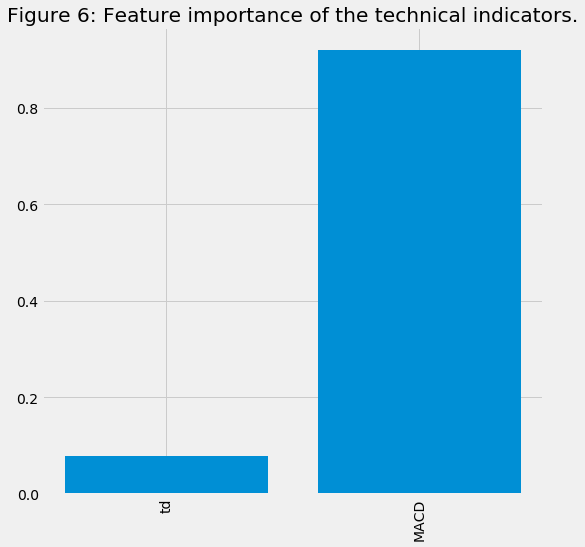

In [28]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [ ]:
import seaborn as sns
def correlation(data):
    C = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(C, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(C, mask = mask, annot = True, cmap = cmap, vmax = .3, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .5})
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() 

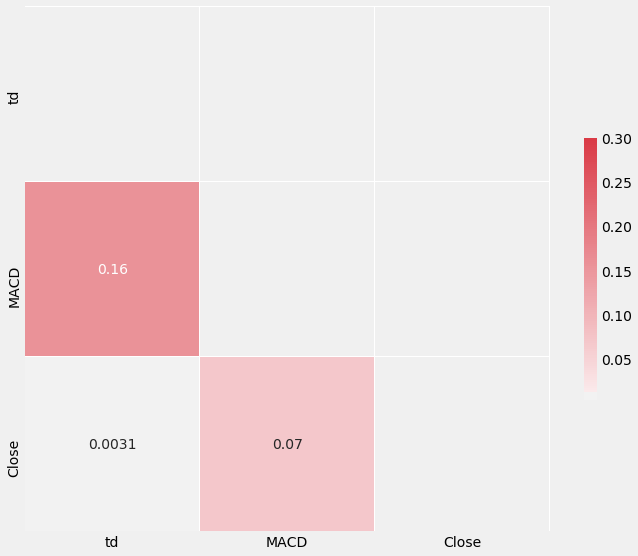

In [30]:
correlation(df)

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [ ]:
TRAIN_SPLIT = int(.80*df.shape[0])

In [33]:
uni_data = df['Close']
uni_data.tail()

Date
2019-11-28 03-PM    7621.76
2019-11-28 04-PM    7616.27
2019-11-28 05-PM    7590.09
2019-11-28 06-PM    7598.79
2019-11-28 07-PM    7626.92
Name: Close, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7feaeccf96a0>],
      dtype=object)

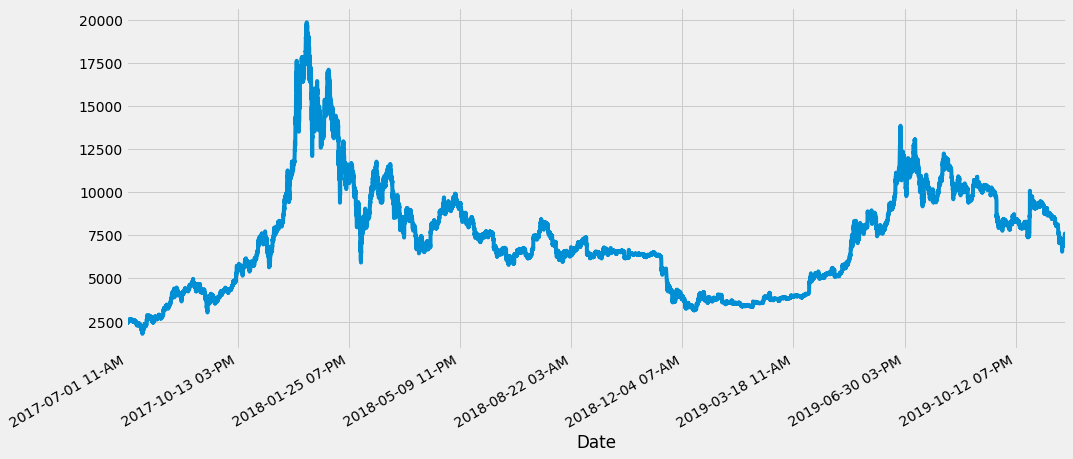

In [34]:
uni_data.plot(subplots=True, figsize=(15,7))

In [ ]:
uni_data = uni_data.values

In [ ]:
uni_data =  uni_data.reshape(-1, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
uni_data = sc.fit_transform(uni_data)

In [38]:
uni_data

array([[0.04009279],
       [0.03894453],
       [0.03706214],
       ...,
       [0.32139563],
       [0.3218773 ],
       [0.32343471]])

In [ ]:
"""
Let's now create the data for the univariate model. In this part, the model will be given the last 30 recorded observations,
and needs to learn to predict the price at the next time step.
"""
univariate_past_history = 24
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [40]:
print ('Single window of past history')
print (x_train_uni[1000])
print ('\n Target price to predict')
print (y_train_uni[1000])

Single window of past history
[[0.10463014]
 [0.10796031]
 [0.10729539]
 [0.10978734]
 [0.11178268]
 [0.11095   ]
 [0.11250408]
 [0.11283959]
 [0.11350064]
 [0.1117251 ]
 [0.11153631]
 [0.11187348]
 [0.1163569 ]
 [0.11438205]
 [0.11655012]
 [0.11654736]
 [0.11687401]
 [0.11198255]
 [0.11252512]
 [0.11409637]
 [0.11565599]
 [0.11914285]
 [0.1234419 ]
 [0.12739382]]

 Target price to predict
[0.12574341]


In [ ]:
### Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [ ]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

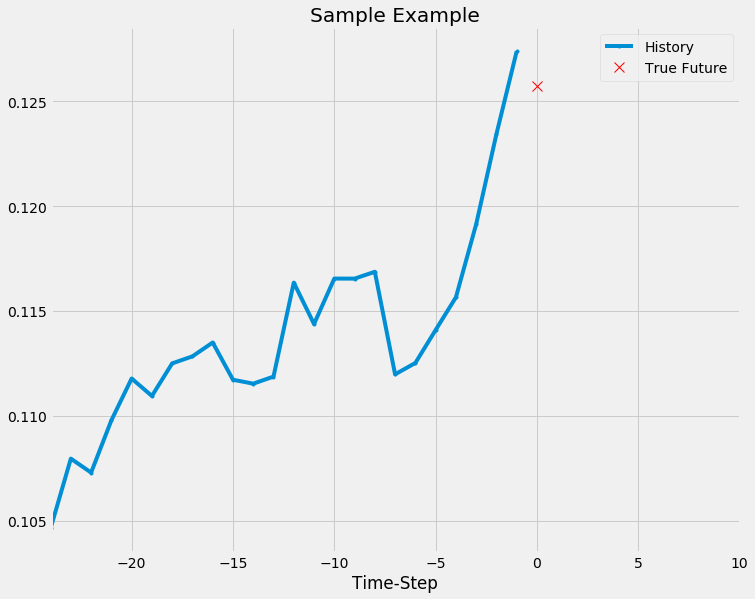

In [44]:
show_plot([x_train_uni[1000], y_train_uni[1000]], 0, 'Sample Example')

(24, 1) (1,) ()


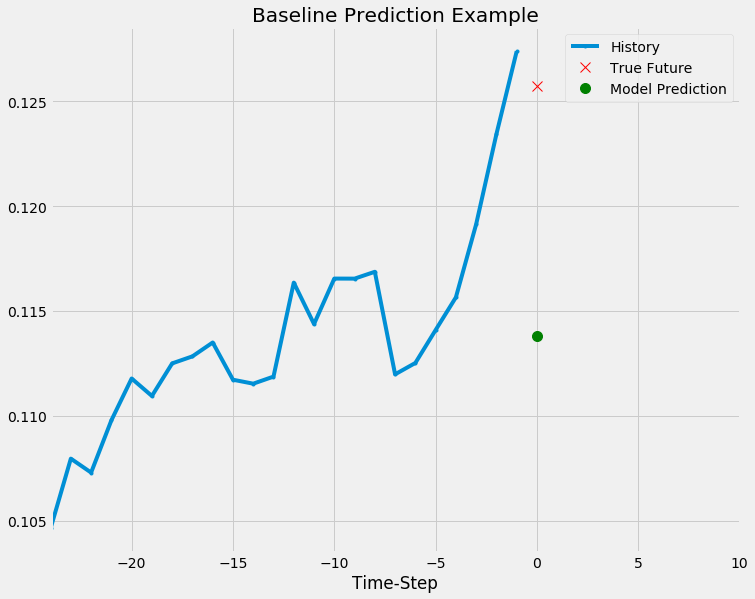

In [45]:
### Baseline
# Before proceeding to train a model, let's first set a simple baseline. 
# Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 30 observations.

def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[1000], y_train_uni[1000], baseline(x_train_uni[1000])], 0, 'Baseline Prediction Example')

print(x_train_uni[1000].shape, y_train_uni[1000].shape, baseline(x_train_uni[0]).shape)

### Univariate

In [46]:
### RNN

# tf.data to shuffle, batch, and cache the dataset.
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

weight_decay = 0.00005
UV = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32,return_sequences=False, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
UV.compile(optimizer='adam',loss='mae')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [47]:
UV.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3264      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Load any existing weights
if os.path.exists(os.path.join(path, 'UV.h5')):
    UV.load_weights(os.path.join(path, 'UV.h5'))
    epochs = 0
else:
    epochs = 5

UV.fit(train_univariate, epochs = epochs, validation_data = val_univariate, steps_per_epoch = x_train_uni.shape[0]//BATCH_SIZE, validation_steps = x_val_uni.shape[0]//BATCH_SIZE)

Train for 65 steps, validate for 16 steps
Epoch 1/5
65/65 [==============================] - 3s 44ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 2/5
65/65 [==============================] - 3s 44ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 3/5
65/65 [==============================] - 3s 44ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 4/5
65/65 [==============================] - 3s 44ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 5/5
65/65 [==============================] - 3s 43ms/step - loss: 0.0026 - val_loss: 0.0028


In [ ]:
if epochs!=0:
    UV.save_weights(os.path.join(path, 'UV.h5'))

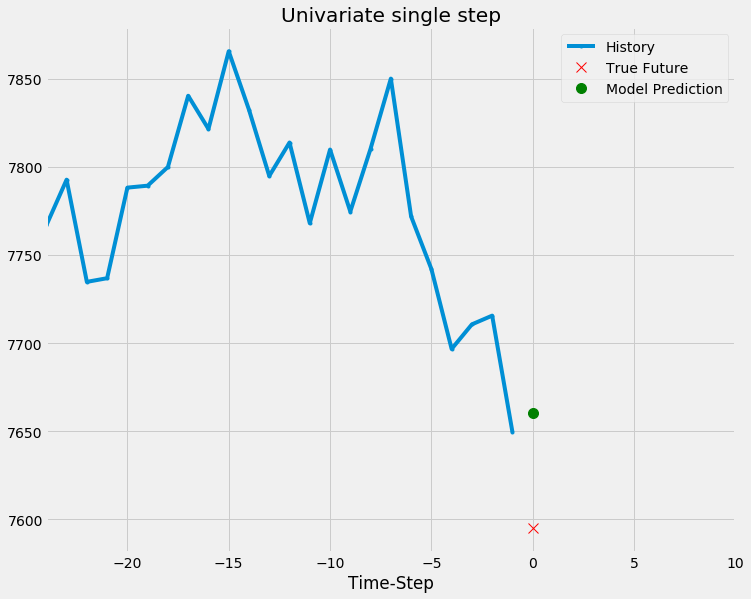

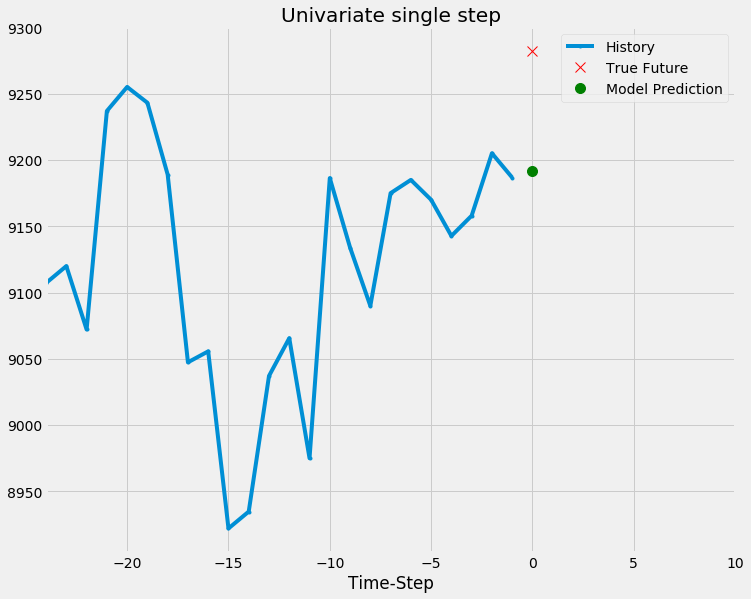

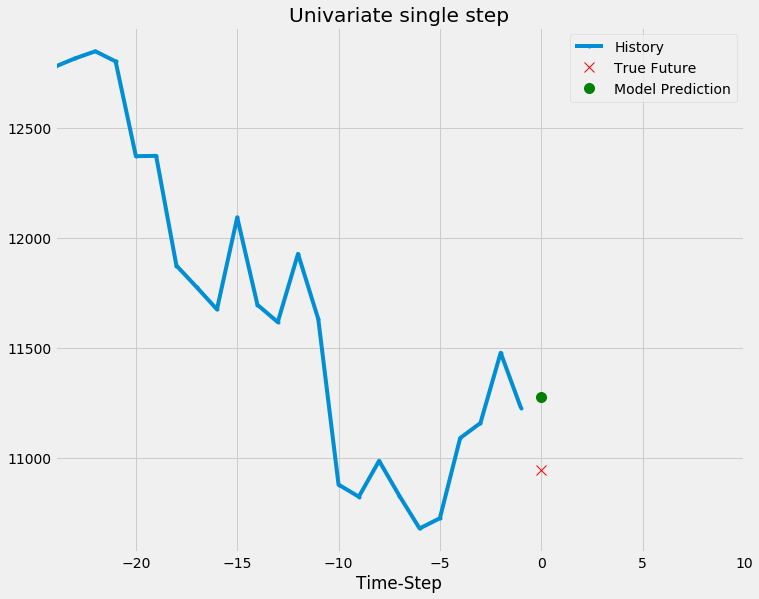

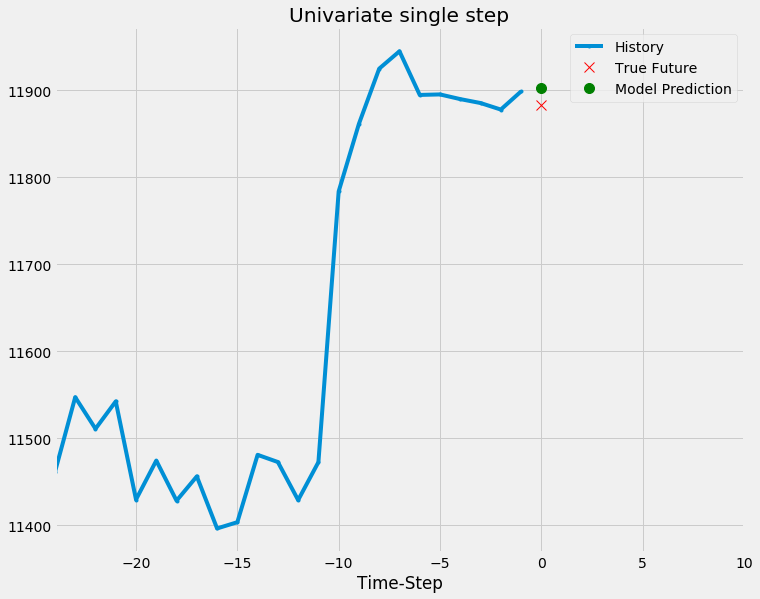

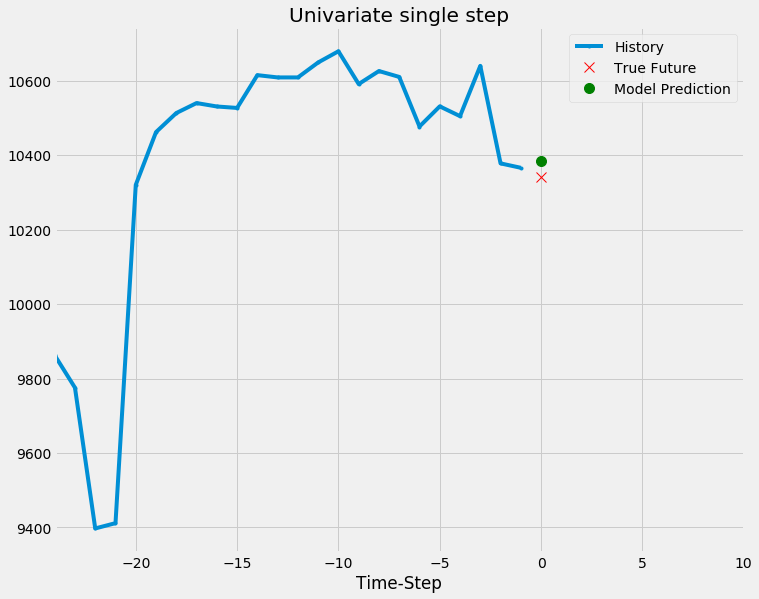

In [52]:
for x, y in val_univariate.take(5):
    plot = show_plot([sc.inverse_transform(x[0].numpy()), sc.inverse_transform(y[0].numpy().reshape(-1, 1)), 
                      sc.inverse_transform(UV.predict(x)[0].reshape(-1, 1))], 0, 'Univariate single step')
    plot.show()

#### CRNN

In [ ]:
### RNN

# tf.data to shuffle, batch, and cache the dataset.
univariate_past_history = 168
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
weight_decay = 0.0000#5

UV_CRNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, 3, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape =x_train_uni.shape[-2:]),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.GRU(128, kernel_regularizer = regularizers.l2(weight_decay)),
    tf.keras.layers.Dense(1)
])

UV_CRNN.compile(optimizer='adam',loss='mae')

In [67]:
UV_CRNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 166, 128)          512       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 83, 128)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 99,329
Trainable params: 99,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load any existing weights
if os.path.exists(os.path.join(path, 'UV_CRNN.h5')):
    UV_CRNN.load_weights(os.path.join(path, 'UV_CRNN.h5'))
    epochs = 0
else:
    epochs = 50

UV_CRNN.fit(train_univariate, epochs = epochs, validation_data = val_univariate, steps_per_epoch = x_train_uni.shape[0]//BATCH_SIZE, validation_steps = x_val_uni.shape[0]//BATCH_SIZE)

In [ ]:
if epochs!=0:
    UV.save_weights(os.path.join(path, 'UV_CRNN.h5'))

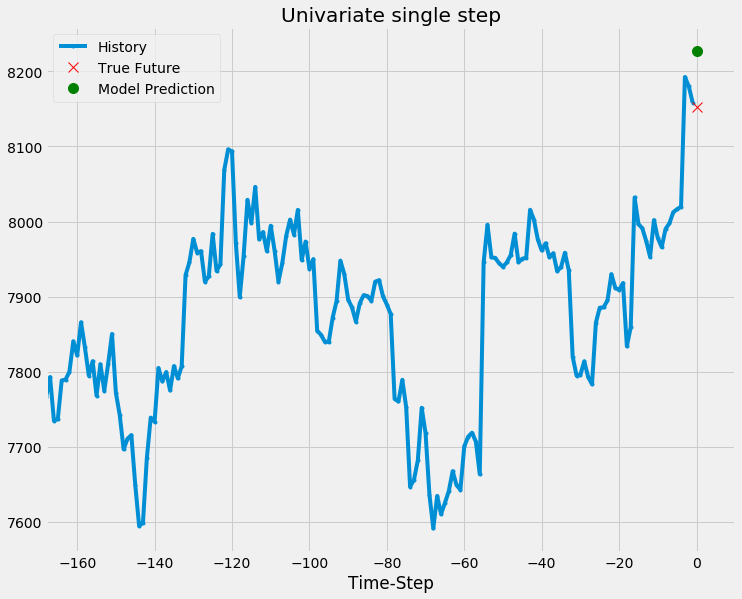

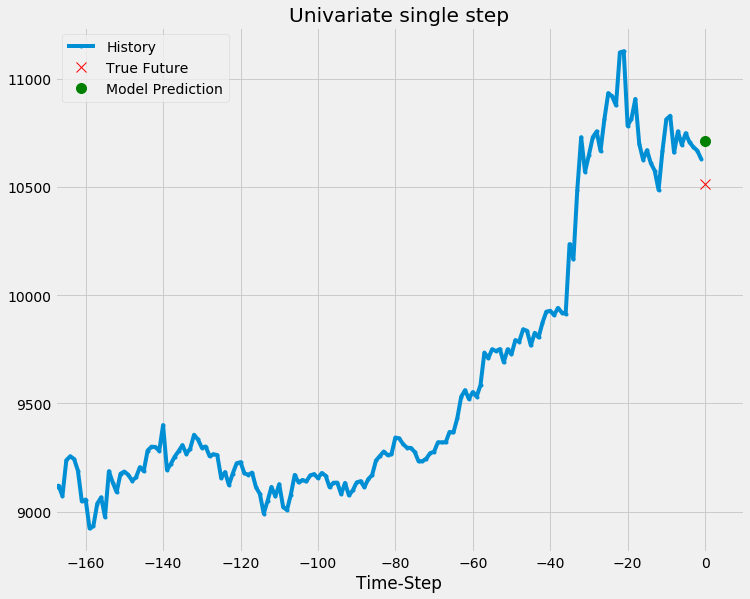

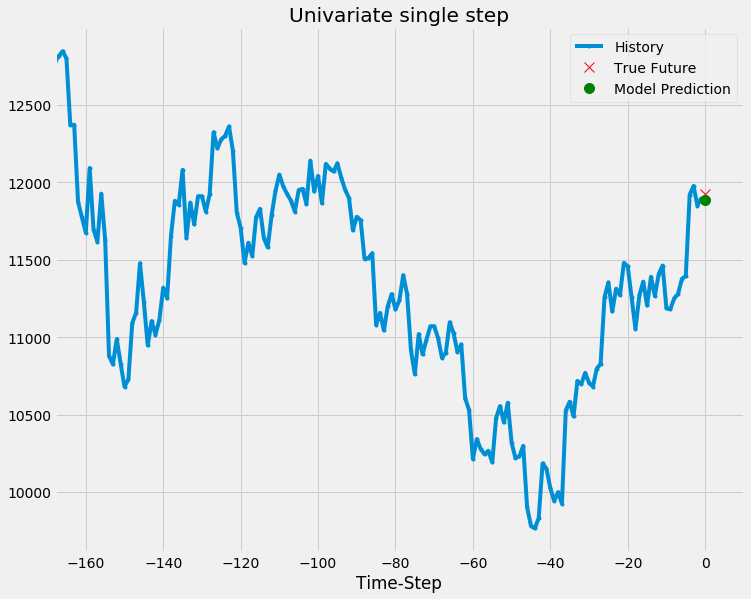

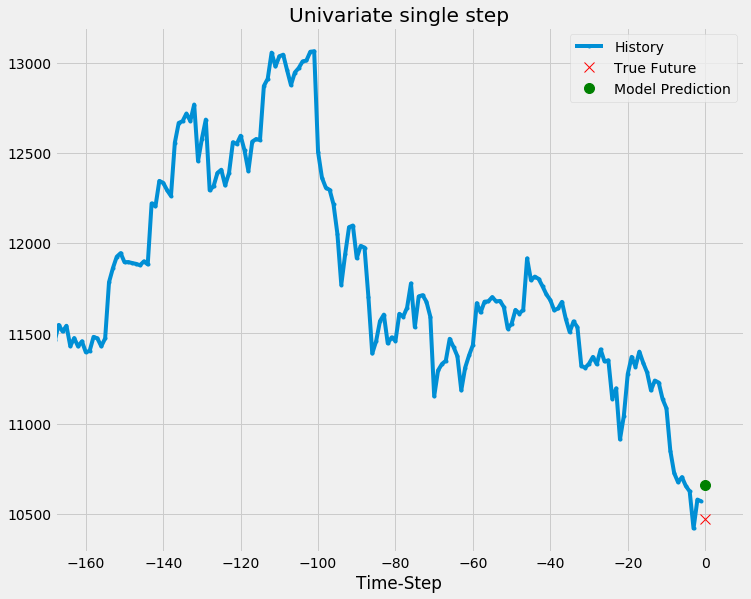

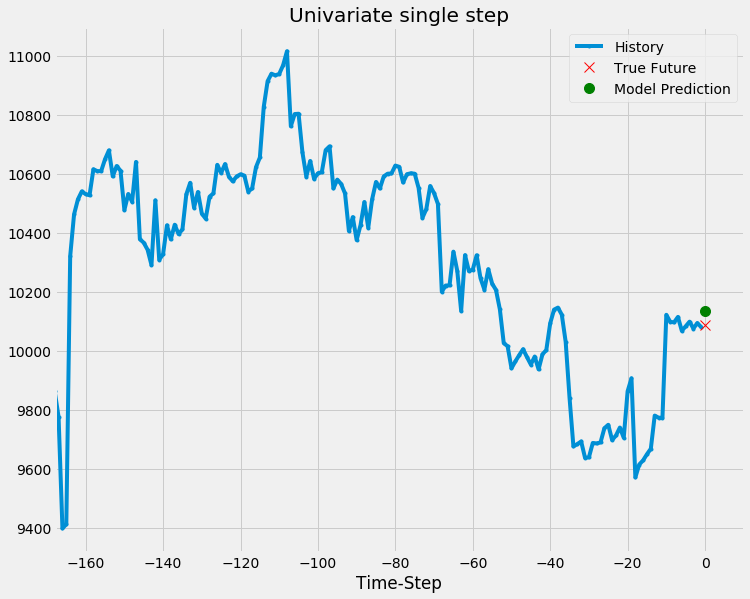

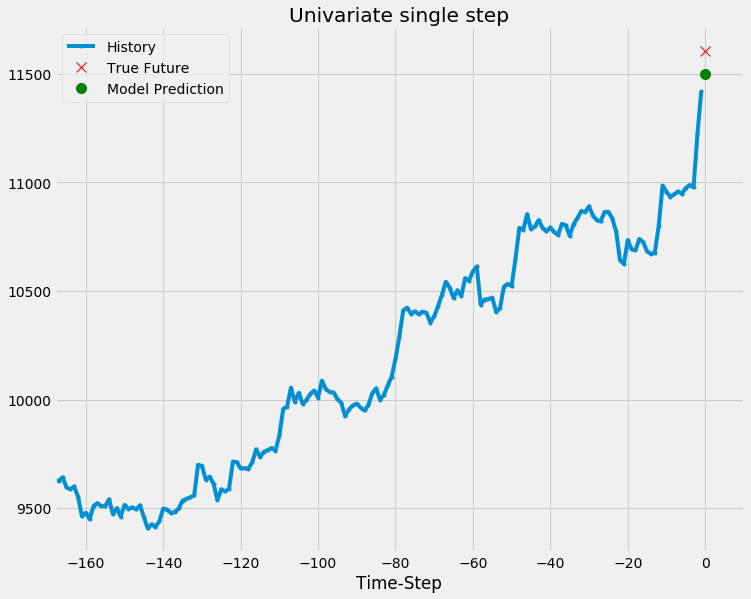

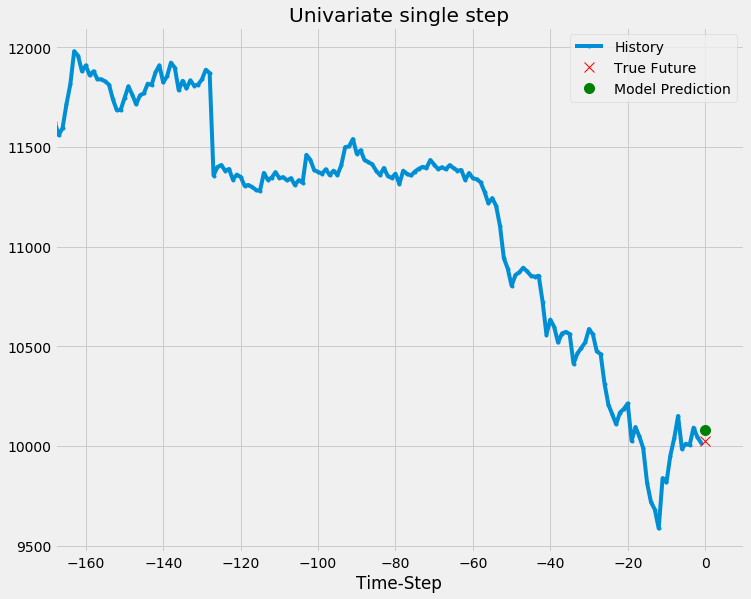

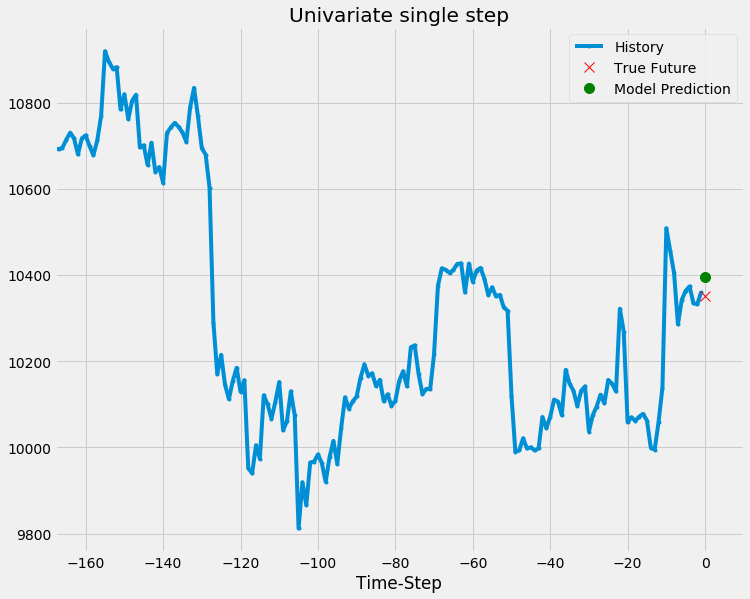

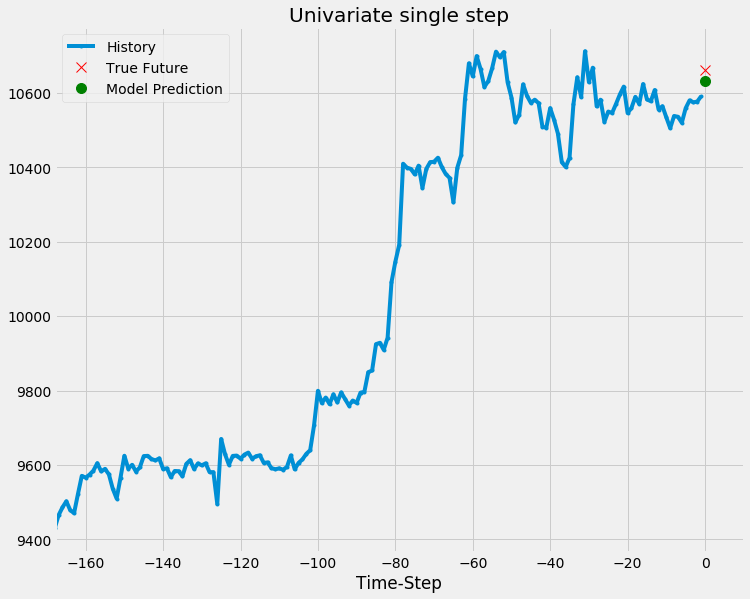

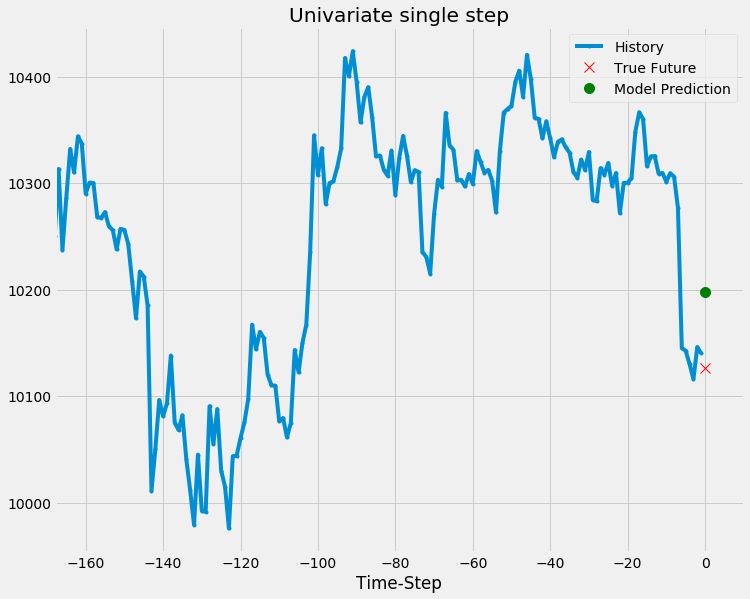

In [70]:
for x, y in val_univariate.take(10):
    plot = show_plot([sc.inverse_transform(x[0].numpy()), sc.inverse_transform(y[0].numpy().reshape(-1, 1)), 
                      sc.inverse_transform(UV_CRNN.predict(x)[0].reshape(-1, 1))], 0, 'Univariate single step')
    plot.show()

### Multivariate

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [456]:
multi_data = np.array(df) #dataset
multi_data.shape, multi_data

((21129, 3), array([[ 0.00000000e+00,  0.00000000e+00,  2.50917000e+03],
        [ 0.00000000e+00, -1.55761218e-01,  2.48843000e+03],
        [ 0.00000000e+00, -1.04946099e+00,  2.45443000e+03],
        ...,
        [ 3.00000000e+00,  5.63360705e+01,  7.59009000e+03],
        [ 4.00000000e+00,  5.85592195e+01,  7.59879000e+03],
        [ 5.00000000e+00,  6.02586757e+01,  7.62692000e+03]]))

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scm = MinMaxScaler(feature_range=(-1, 1))
std = StandardScaler()
multi_data = scm.fit_transform(multi_data)

In [458]:
multi_data

array([[ 0.        , -0.04318479, -0.91981442],
       [ 0.        , -0.0433598 , -0.92211094],
       [ 0.        , -0.04436391, -0.92587573],
       ...,
       [ 0.33333333,  0.02011144, -0.35720874],
       [ 0.44444444,  0.02260925, -0.3562454 ],
       [ 0.55555556,  0.02451867, -0.35313059]])

In [ ]:
past_history = 72
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(multi_data, multi_data[:, 2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(multi_data, multi_data[:, 2],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [461]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (72, 3)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
weight_decay = 0.000#5

SS_MV = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32,return_sequences=False, input_shape=x_train_single.shape[-2:]),
    tf.keras.layers.Dense(1)
])
sgd = tf.keras.optimizers.SGD(lr=1e-2, momentum = .8, decay = 1e-6, nesterov = False)
SS_MV.compile(optimizer = 'adam',loss='mae')

In [487]:
for x, y in val_data_single.take(1):
    print(SS_MV.predict(x).shape)

(256, 1)


In [488]:
SS_MV.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 (None, 32)                3456      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 3,489
Trainable params: 3,489
Non-trainable params: 0
_________________________________________________________________


In [489]:
# Load any existing weights
if os.path.exists(os.path.join(path, 'SS_MV.h5')):
    SS_MV.load_weights(os.path.join(path, 'SS_MV.h5'))
    epochs = 0
else:
    epochs = 50

single_step = SS_MV.fit(train_data_single, epochs = epochs, validation_data = val_data_single, steps_per_epoch = x_train_single.shape[0]//BATCH_SIZE, validation_steps = x_val_single.shape[0]//BATCH_SIZE)

Train for 65 steps, validate for 16 steps
Epoch 1/50
65/65 [==============================] - 10s 150ms/step - loss: 0.0407 - val_loss: 0.0085
Epoch 2/50
65/65 [==============================] - 8s 124ms/step - loss: 0.0070 - val_loss: 0.0085
Epoch 3/50
65/65 [==============================] - 8s 121ms/step - loss: 0.0069 - val_loss: 0.0079
Epoch 4/50
65/65 [==============================] - 8s 121ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 5/50
65/65 [==============================] - 8s 121ms/step - loss: 0.0063 - val_loss: 0.0076
Epoch 6/50
65/65 [==============================] - 8s 124ms/step - loss: 0.0063 - val_loss: 0.0076
Epoch 7/50
65/65 [==============================] - 8s 124ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 8/50
65/65 [==============================] - 8s 122ms/step - loss: 0.0061 - val_loss: 0.0070
Epoch 9/50
65/65 [==============================] - 8s 121ms/step - loss: 0.0063 - val_loss: 0.0078
Epoch 10/50
65/65 [==============================] - 8s 1

In [ ]:
if epochs!=0:
    SS_MV.save_weights(os.path.join(path, 'SS_MV.h5'))

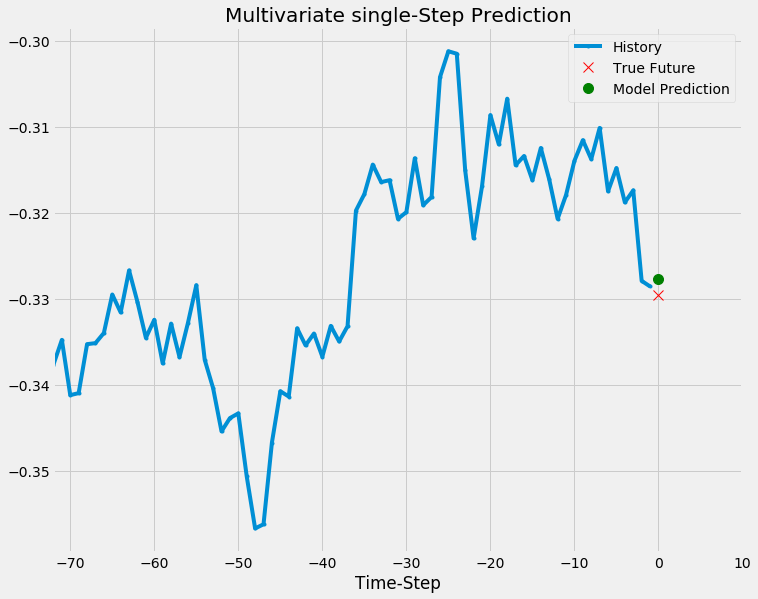

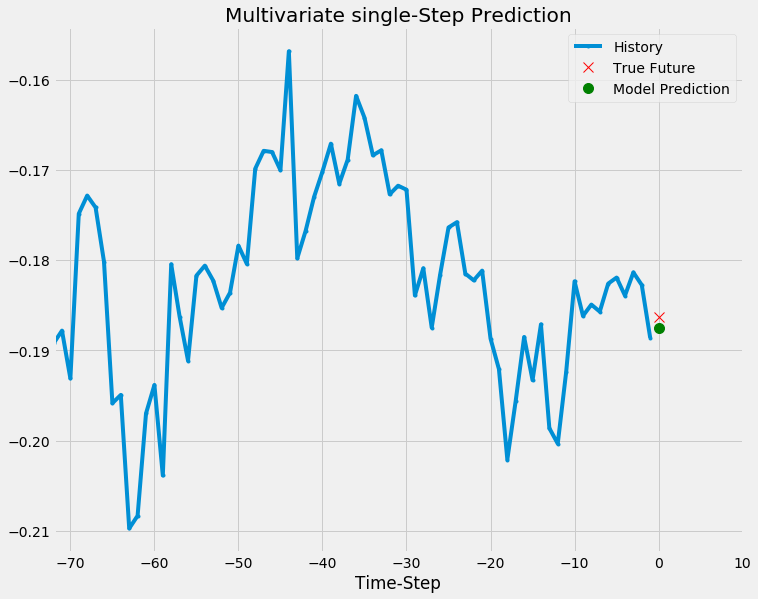

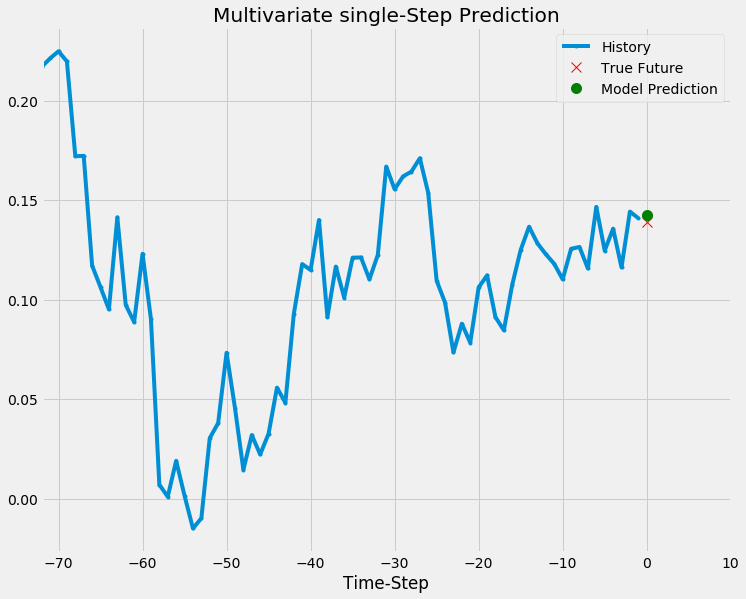

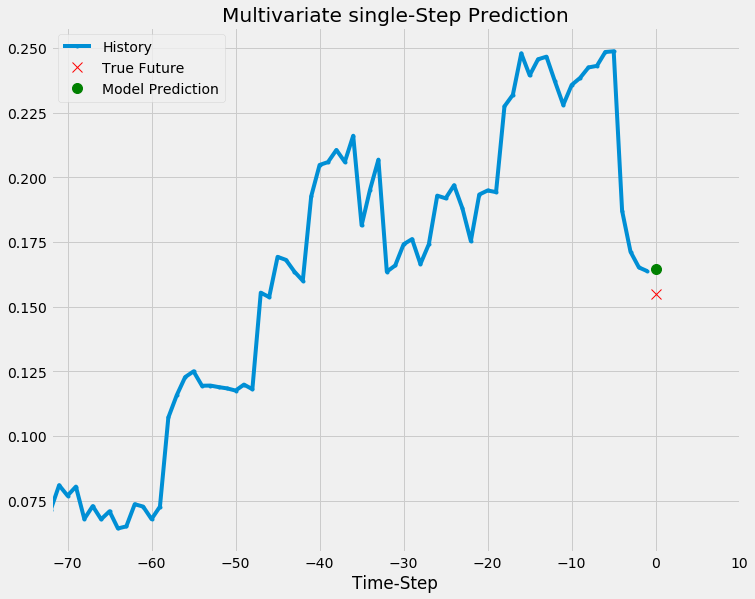

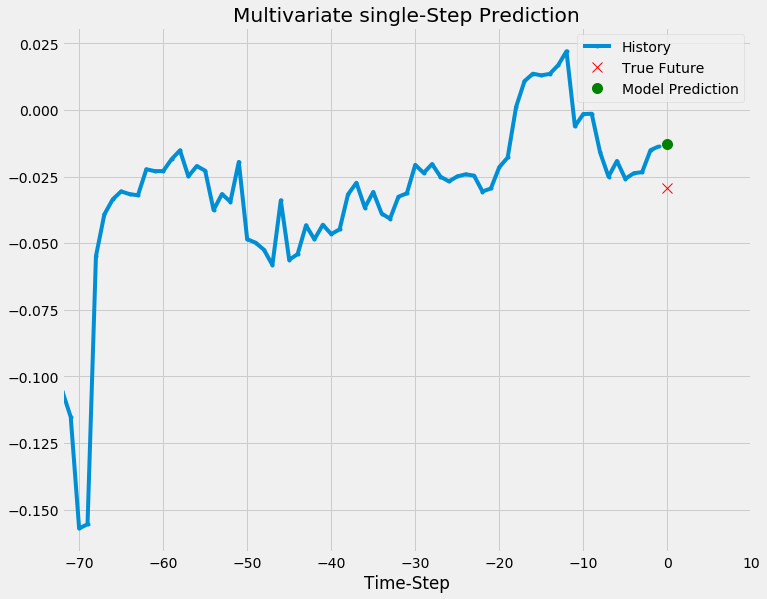

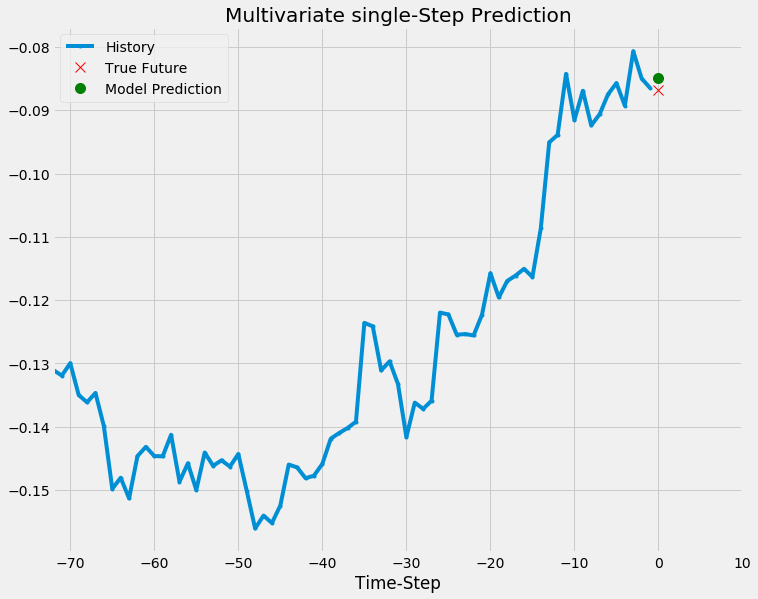

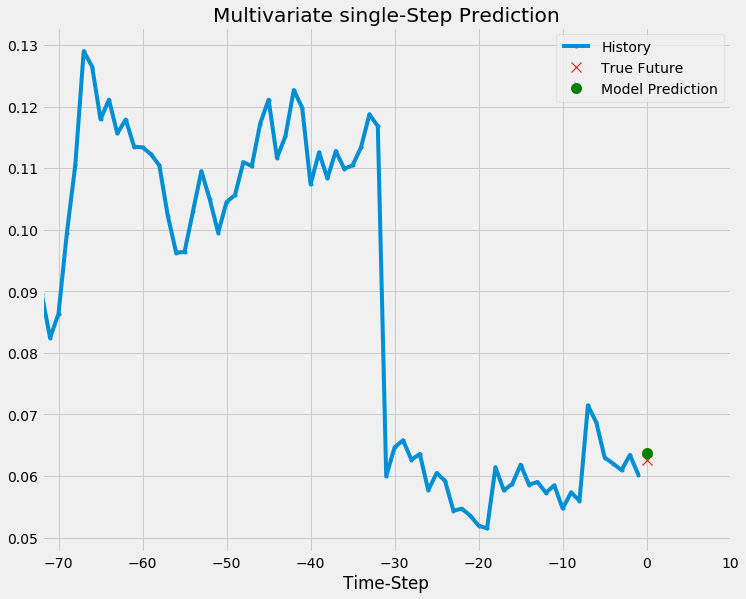

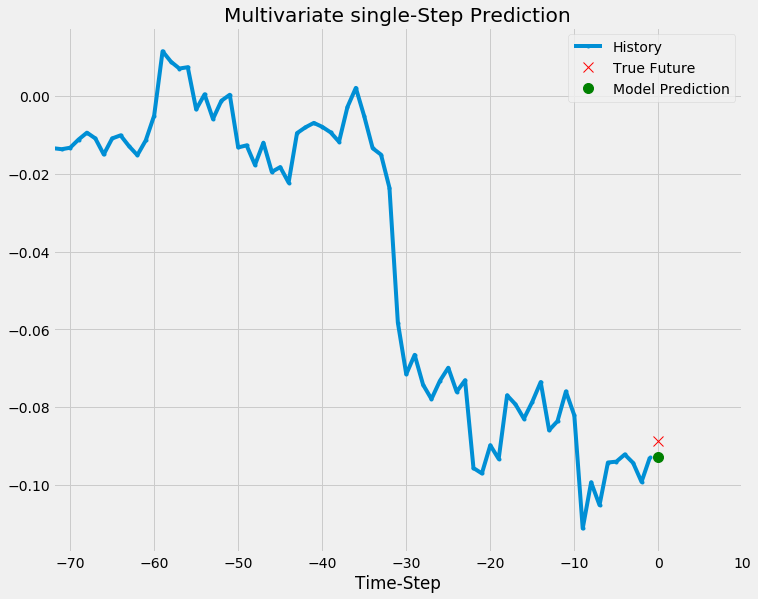

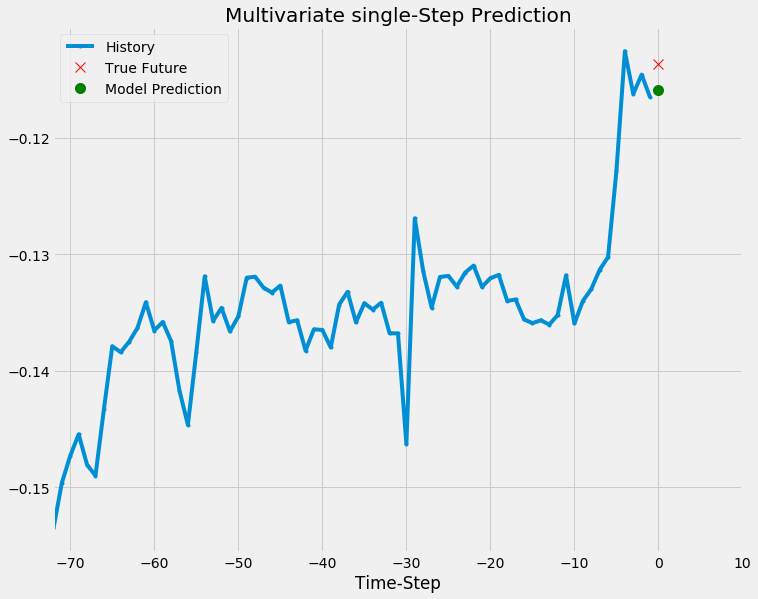

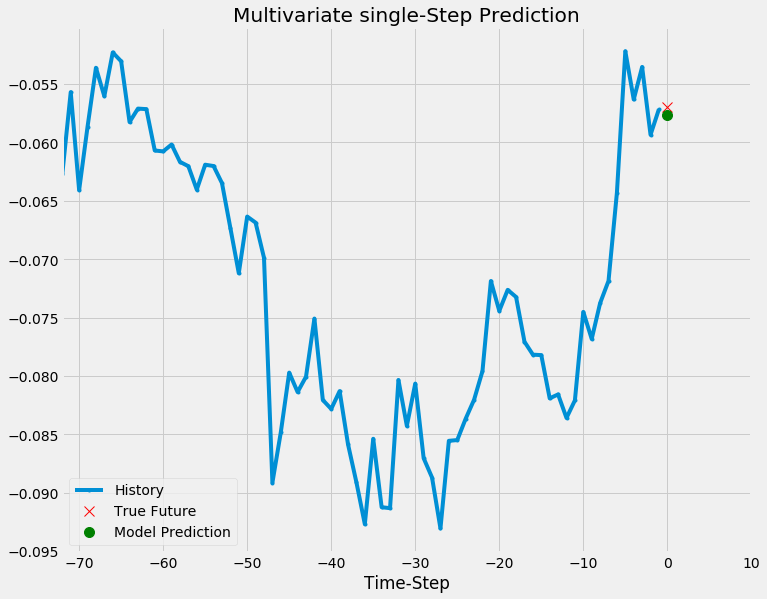

In [492]:
# Single step prediction

for x, y in val_data_single.take(10):
    plot = show_plot([x[0][:,2].numpy(), y[0].numpy(), SS_MV.predict(x)[0]], 0, 'Multivariate single-Step Prediction')
    plot.show()